In [12]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
#export
from local.torch_basics import *
from local.test import *
from local.data.all import *
from local.vision.core import *
from local.notebook.showdoc import show_doc
from local.audio.core import *
from local.audio.augment import *
from local.learner import *
from local.vision.models.xresnet import *
from local.metrics import *

In [14]:
p = Config()['data_path'] / 'ST-AEDS-20180100_1-OS'
x = AudioGetter("", recurse=True, folders=None)
files = x(p)
sample_file = p / 'm0005_us_m0005_00218.wav'
original_aud = AudioItem.create(sample_file)

In [15]:
a2s = AudioToSpec(n_fft = 1024, hop_length=256)

In [16]:
original_spec = a2s(original_aud)

In [17]:
type(original_spec[0])

torch.Tensor

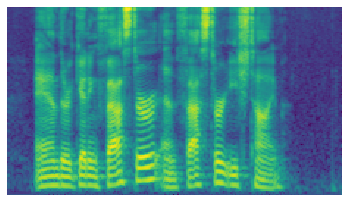

In [18]:
original_spec.show()

In [19]:
original_spec.n_fft

1024

# End-to-End Example

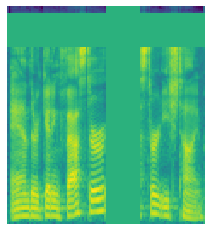

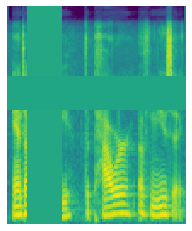

In [20]:
items = get_audio_files(p)
oa = OpenAudio(items)
preprocesses = [oa, RemoveSilence("trim"), Resample(22050),]
augments = [AudioToSpec(n_fft=1048), MaskTime(), MaskFreq()]
functions = preprocesses + augments
pipe = Pipeline(functions, as_item=True)
for i in range(2): pipe.show(pipe(i))

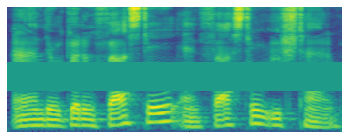

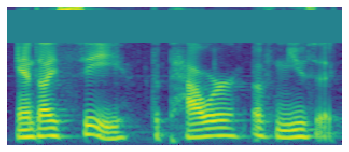

In [21]:
oa = OpenAudio(items)
preprocesses = [oa, RemoveSilence("trim"), Resample(16000),]
short_hop_mel = MelSpectrogramConfig(hop_length=128, n_fft=1024)
augments = [AudioToSpec.from_cfg(short_hop_mel), MaskFreq(size=30)]
functions = preprocesses + augments
pipe = Pipeline(functions, as_item=True)
for i in range(2): pipe.show(pipe(i))

<div class='alert alert-block alert-warning'><strong>Warning:</strong>By default AudioToSpec will use the default arguments of the specified _GenSpec() function (currently wraps torchaudio.transforms.MelSpectrogram). In that function the defaults are awful, and hop_length defaults to None. We don't currently pass along arguments whose value is None to be stored as attributes of the AudioSpectrogram object, so if no hop_length is specified, CropTime won't work. Not sure the best fix right now so I'm leaving it as an open issue. Likely we will override MelSpectrograms default hop_length, because having a default hop_length is important because without it you cant interpret the x-axis of a spectrogram. The other option is storing a duration attribute directly in the spectrogram. This would allow us to have access to the scale of the x-axis without a hop, and we could avoid the repetition of calculating time duration from hop/sr/samples.

First example below demonstrates the problem. No hop_length is specified for AudioToSpec -> error: AudioSpectrogram object has no attribute hop_length

Second example demonstrates a working version by passing a hop_length
</div>

<div class='alert alert-block alert-info'><strong>Note:</strong> Next cell demonstrates a bug and is meant to fail!
</div>

In [22]:
labeler = lambda x: str(x).split('/')[-1][:5]
tfms = [[AudioItem.create, Resample(8000)], [labeler]]
items = get_audio_files(p)

tds = TfmdDS(items, tfms)
tds.show(tds[0])
tdl = TfmdDL(tds, bs=8, after_item=[AudioToSpec(), CropTime(1000), MaskTime(), MaskFreq()])

NameError: name 'TfmdDS' is not defined

In [23]:
labeler = lambda x: str(x).split('/')[-1][:5]
tfms = [[AudioItem.create, Resample(8000)], [labeler]]
items = get_audio_files(p)

tfds = TfmdDS(items, tfms)
tfds.show(tfds[0])
bs = 8
tfdl = TfmdDL(tfds, bs=bs, after_item=[AudioToSpec(hop_length=256), CropTime(1000), MaskTime(), MaskFreq()])

NameError: name 'TfmdDS' is not defined

In [24]:
t = tfdl.one_batch()
print(len(t[0]), "tensors with shapes", [ten.shape for ten in t[0]])
print("labels", t[1])

NameError: name 'tfdl' is not defined

<div class = "alert alert-block alert-info"><strong>TO-DO:</strong> `decode_batch` and `show_batch` are causing recursion errors in the following two cells</div>


In [ ]:
#tfdl.show_batch(max_n=4)

In [ ]:
# batch = tfdl.one_batch()
# test_eq(len(batch[0]), bs)
# test_eq(len(batch[1]), bs)
# tfdl.decode_batch(batch)

## Datablock and Basic End to End Training

In [ ]:
auds = DataBlock(ts=(AudioItem, Category), 
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 get_y=lambda x: str(x).split('/')[-1][:5])

In [ ]:
cats = [y for _,y in auds.datasource(p)]

In [ ]:
#verify categories are being correctly assigned
min(cats), max(cats)

<div class = "alert alert-block alert-warning">Because we haven't adjusted the standard learner to handle 1 channel input, we have to just stack the spectrograms to 3 channels using expand to see if we can get an actual end-to-end training example</div>

In [ ]:
def Stack3Channels():
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        sg = spectro.clone().expand(3, -1, -1)
        return AudioSpectrogram.create(sg, settings=spectro.settings)
    return _inner

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
a2s = AudioToSpec(n_fft = 1024, hop_length=256)
crop_2000ms = CropTime(2000)
tfms = Pipeline([a2s, crop_2000ms, Stack3Channels()], as_item=True)
dbunch_cropspec = auds.databunch(p, ds_tfms=tfms, bs=64)

In [ ]:
dbunch_cropspec.show_batch(max_n=9)

In [ ]:
dbunch_cropspec.one_batch()[0].shape

In [ ]:
learn = Learner(xresnet18(), 
                dbunch_cropspec, 
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])

In [ ]:
learn.fit(10, lr=3e-2)

## Cropping signal instead of Spectrogram so that we can move on to GPU transforms

In [ ]:
auds = DataBlock(ts=(AudioItem, Category), 
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 get_y=lambda x: str(x).split('/')[-1][:5])

In [ ]:
auds.datasource(p)[0]

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
cropsig_2000ms = CropSignal(2000)
ds_tfms = Pipeline([cropsig_2000ms, a2s, Stack3Channels()], as_item=True)
dl_tfms = Pipeline([], as_item=True)
dbunch_cropsig = auds.databunch(p, ds_tfms=ds_tfms, dl_tfms=dl_tfms, bs=64)
dbunch_cropsig.show_batch(max_n=9)

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
a2s = AudioToSpec(n_fft = 1024, hop_length=256)
cropsig_2000ms = CropSignal(2000)
tfms = Pipeline([cropsig_2000ms, a2s, Stack3Channels()], as_item=True)
dbunch = auds.databunch(p, ds_tfms=tfms, bs=64)
dbunch.show_batch(max_n=9)

In [ ]:
dbunch.one_batch()[0].shape

In [ ]:
learn = Learner(xresnet18(), 
                dbunch, 
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])

In [ ]:
learn.fit(10, lr=3e-2)

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)